In [1]:
#import libraries (always run this before any code below!)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!python --version

Python 3.7.13


## Plot of streamflow observations and residuals

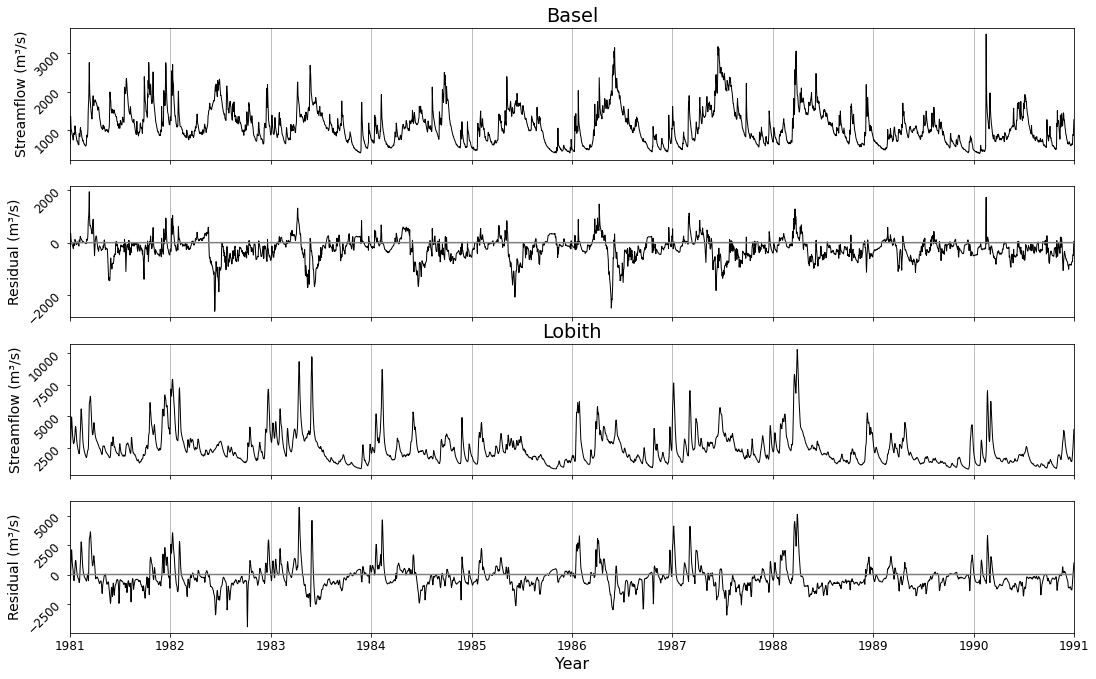

In [ ]:
PERC_SHOWN = 0.5 #the fraction of the imported data to be shown in the figure

#import the data (change path to your own)
q_basel = pd.read_csv('/content/drive/MyDrive/ADS/Final Thesis Project/data/q_basel.csv')
q_lobith = pd.read_csv('/content/drive/MyDrive/ADS/Final Thesis Project/data/q_lobith.csv')

#check if the amount of observations is the same
if q_basel.shape[0] != q_lobith.shape[0]:
  raise ValueError('The number of observations does not coincide.')

#subset the data acording to PERC_SHOWN
len = int(q_basel.shape[0]*PERC_SHOWN)
q_basel = q_basel.iloc[:len, :]
q_lobith = q_lobith.iloc[:len, :]

#extract the observations, residuals and dates
obs_b = q_basel['obs'].values
res_b = q_basel['res'].values

obs_l = q_lobith['obs'].values
res_l = q_lobith['res'].values

yr = q_basel['datetime'].str[:4].values

#plot the observations and residuals
plt.rcParams.update({'font.size': 16})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(18, 18*2/(1+5**0.5)))
ax1.plot(obs_b, 'k',  linewidth='1')
ax2.plot(res_b, 'k',  linewidth='1')
ax3.plot(obs_l, 'k',  linewidth='1')
ax4.plot(res_l, 'k',  linewidth='1')
ax2.plot(np.zeros(len), color='gray')
ax4.plot(np.zeros(len), color='gray')

#set the ticks
days_per_year = [0]+[365, 365, 365, 366]*5
ticks = np.cumsum(days_per_year[:-1])[:int(20*PERC_SHOWN)]
plt.xticks(ticks.tolist() + [len], 
           yr[ticks].tolist() + [str(int(yr[-1]) + 1)])
#tweak the axes
ax1.title.set_text('Basel')
ax3.title.set_text('Lobith')
ax4.set_xlabel('Year')
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax2.set_ylabel('Residual (m³/s)', fontsize = 14)
ax3.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax4.set_ylabel('Residual (m³/s)', fontsize = 14)
plt.xlim([0, len])
for ax in (ax1, ax2, ax3, ax4):
  ax.grid(axis = 'x')
  ax.tick_params(axis='y', labelsize=12,  rotation = 45)
  ax.tick_params(axis='x', labelsize=12)

#save the figure (change path to your own)
plt.savefig('/content/drive/MyDrive/ADS/Final Thesis Project/output/obs_res.png',bbox_inches='tight')

## Plot of predictions vs date

Test data length: 1449, Used length: 731


Text(0.5, 0, 'Date')

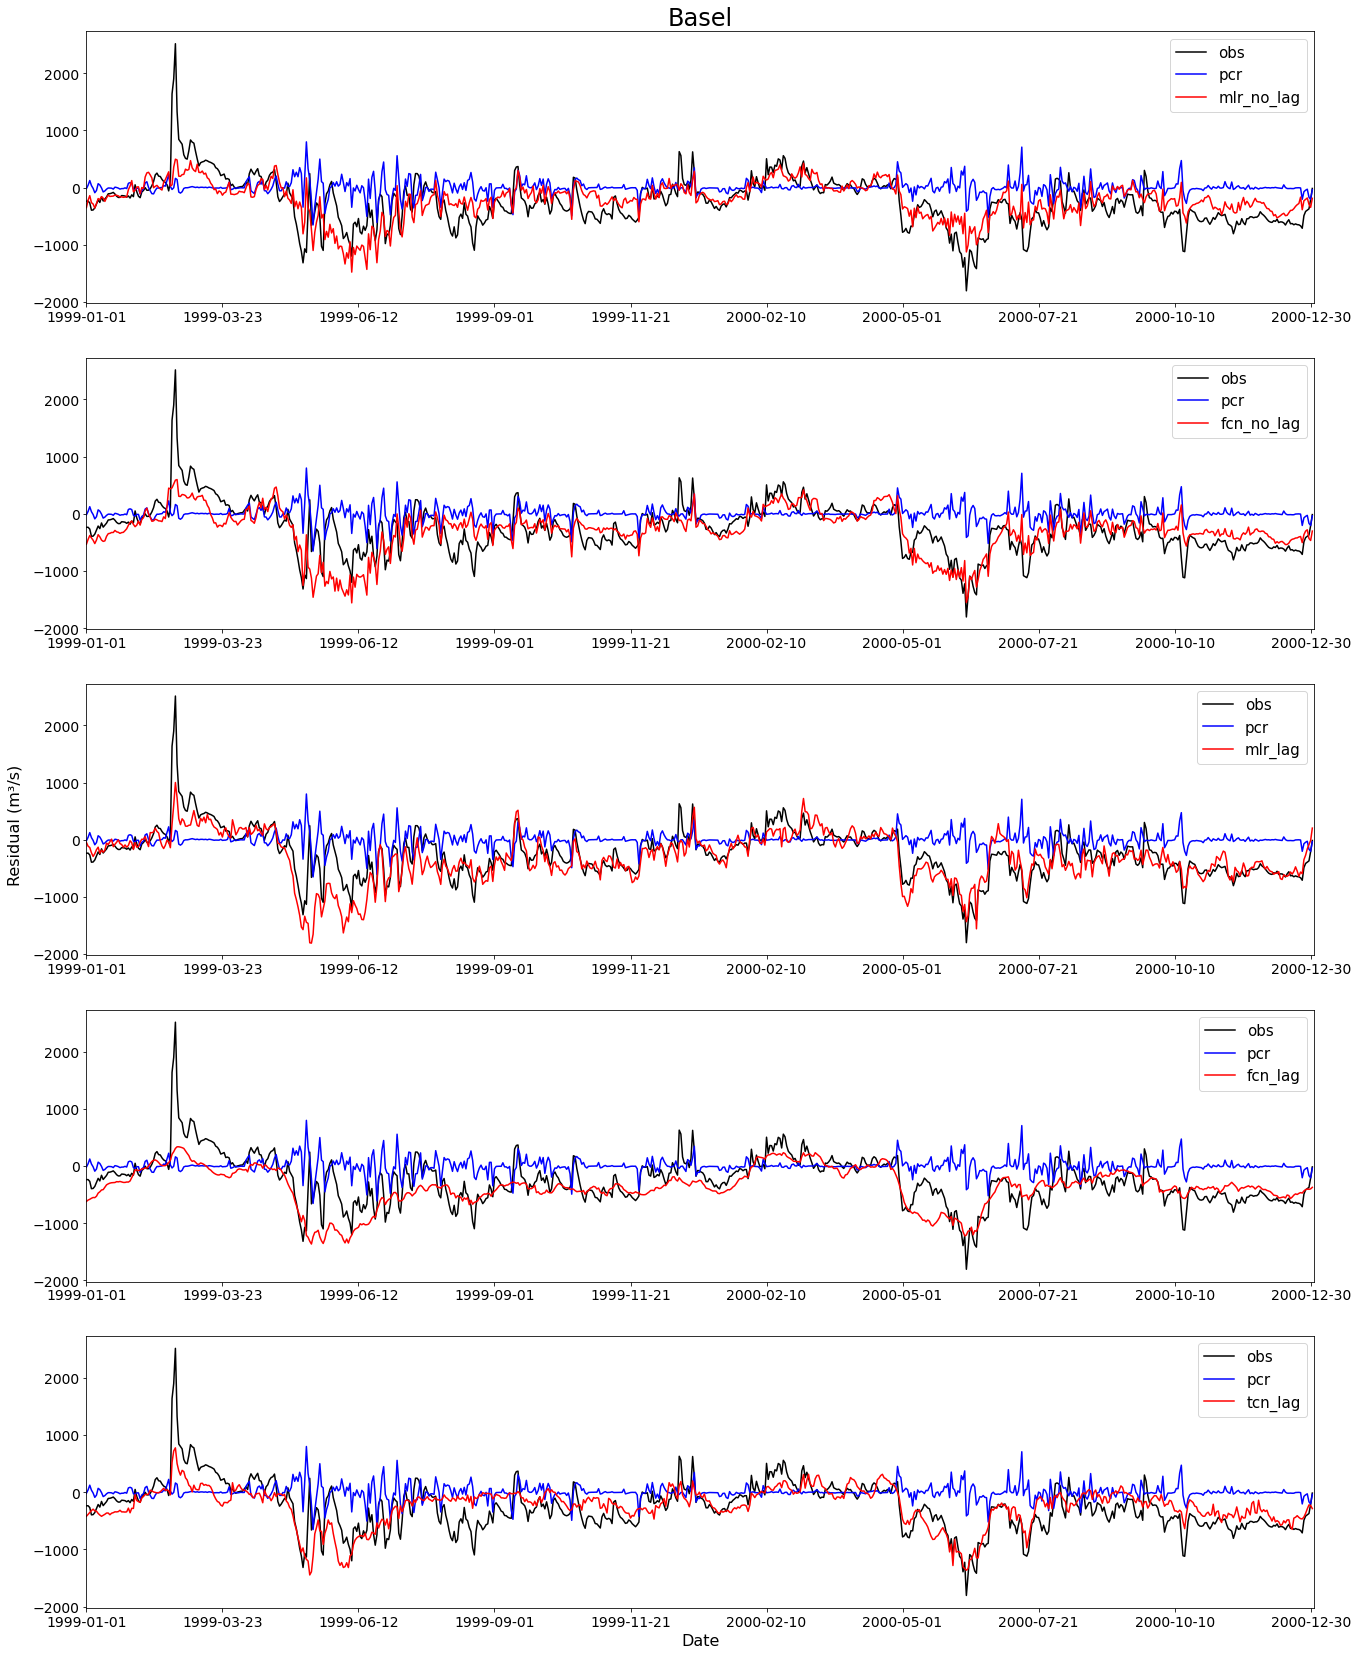

In [ ]:
RESIDUAL = True          #whether to plot the residuals or the streamflow
LOCATION = 'basel'       #location of the data to be plotted
N_TICKS = 10             #number of ticks in the x axis
DAYS_SHOWN = 365*2 + 1   #number of days (or observations) to be plotted

#define what models to use
models = [['pcr', 'no_lag'], ['mlr', 'no_lag'], ['fcn', 'no_lag'], 
          ['mlr', 'lag'], ['fcn', 'lag'], ['tcn', 'lag']]
model_pred = []

#import the data (change paths to your own)
with np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/formatted_data/{LOCATION}/lag_5.npz') as f:
  _, _, _, y, obs = list(f.values())
print(f'Test data length: {len(obs)}, Used length: {DAYS_SHOWN}')
obs = obs[-DAYS_SHOWN:]
y = y[-DAYS_SHOWN:]

for m in models:
  pred = np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/{m[1]}/{m[0]}/{m[0]}_test_5.npy')
  pred = pred[-DAYS_SHOWN:] + (y - obs)*RESIDUAL
  model_pred.append(pred)

if RESIDUAL:
  obs = y

q = pd.read_csv('/content/drive/MyDrive/ADS/Final Thesis Project/data/q_basel.csv')
dates = np.array(q.iloc[-DAYS_SHOWN:,0])

#plot predictions
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(len(models)-1, 1, figsize = (22,5*len(models)-1))
for i in range(1, len(models)):
  ax[i-1].plot(obs, label = "obs", color = 'black')
  ax[i-1].plot(model_pred[0], label = 'pcr', color = 'blue')
  ax[i-1].plot(model_pred[i], label = models[i][0] + '_' + models[i][1], color = 'red')
  ax[i-1].set_xlim(0, DAYS_SHOWN)
  ax[i-1].set_xticks(np.arange(0, len(obs) + 1, len(obs)//(N_TICKS-1)))
  ax[i-1].set_xticklabels(dates[np.arange(0, len(obs), len(obs)//(N_TICKS-1))])
  ax[i-1].legend(prop={'size': 15})

if RESIDUAL:
  fig.text(0.075, 0.5, 'Residual (m³/s)', va='center', rotation='vertical', fontsize = 16)
else:
  fig.text(0.075, 0.5, 'Streamflow (m³/s)', va='center', rotation='vertical', fontsize = 16)

ax[0].set_title(LOCATION.capitalize(), fontsize = 24)
ax[i-1].set_xlabel('Date', fontsize = 16)

#save the figure (change path to your own)
plt.savefig(f'/content/drive/MyDrive/ADS/Final Thesis Project/output/pred_vs_date_{LOCATION}.png',bbox_inches='tight')

## Performance boxplots and significant differences

TCN-FCN with lag basel t-test: Ttest_indResult(statistic=-5.265688556438161, pvalue=0.0025008763512246023)


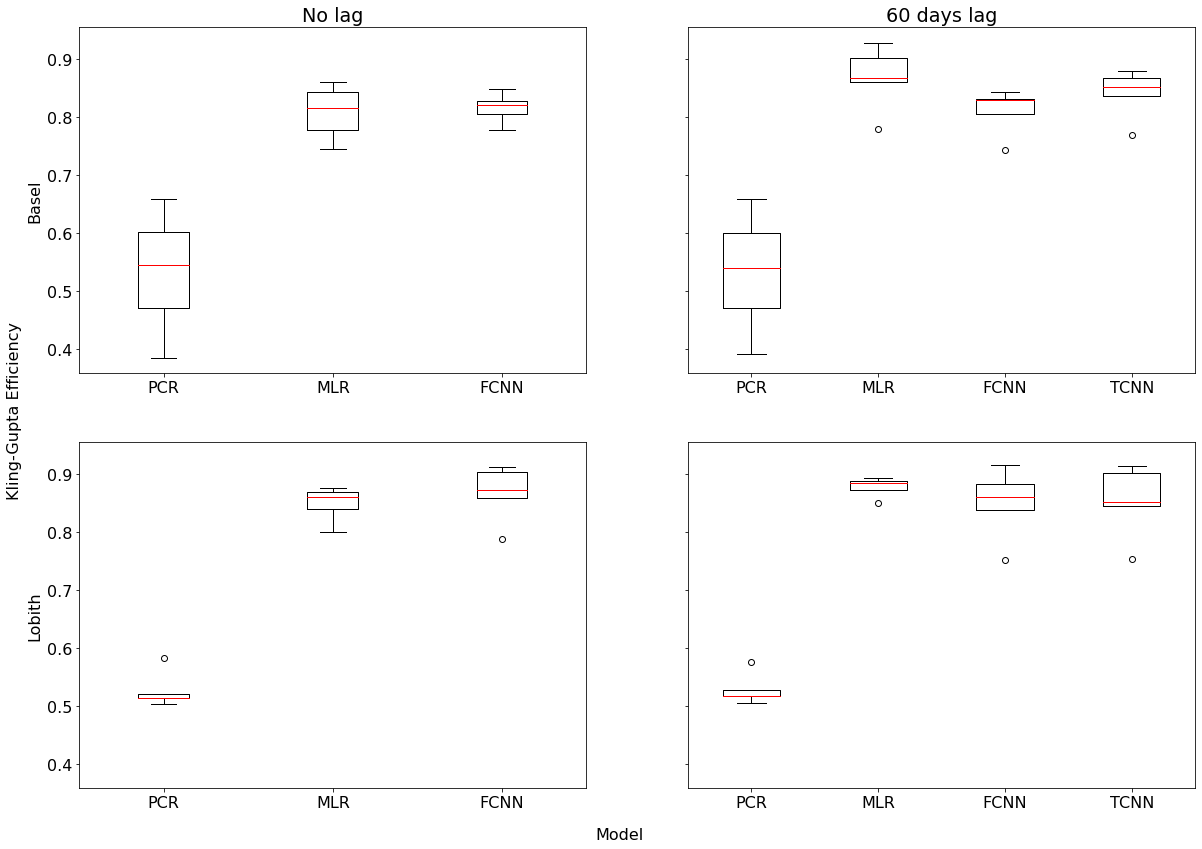

In [ ]:
from scipy.stats import ttest_ind

#handtyped results obtained from running the models
kge_basel_nlag = {'PCR':[0.385, 0.470, 0.545, 0.601, 0.658], 
                  'MLR':[0.745, 0.843, 0.778, 0.860, 0.815], 
                  'FCNN':[0.778, 0.827, 0.805, 0.848, 0.821]}

kge_basel_ylag = {'PCR':[0.392, 0.471, 0.540, 0.600, 0.659], 
                  'MLR':[0.860, 0.927, 0.866, 0.902, 0.779], 
                  'FCNN':[0.742, 0.843, 0.829, 0.831, 0.804],
                  'TCNN':[0.769, 0.879, 0.836, 0.851, 0.867]}

kge_lobith_nlag = {'PCR':[0.521, 0.513, 0.583, 0.513, 0.504], 
                   'MLR':[0.860, 0.868, 0.876, 0.800, 0.839], 
                   'FCNN':[0.859, 0.911, 0.873, 0.904, 0.788]}

kge_lobith_ylag = {'PCR':[0.528, 0.518, 0.576, 0.517, 0.505], 
                   'MLR':[0.872, 0.885, 0.849, 0.887, 0.893], 
                   'FCNN':[0.837, 0.883, 0.860, 0.915, 0.751],
                   'TCNN':[0.902, 0.852, 0.844, 0.914, 0.753]}

#print the t-test of any two models
print('TCN-FCN with lag basel t-test:', ttest_ind(kge_basel_nlag['PCR'], kge_basel_nlag['MLR'], equal_var=False))

#plot the results
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(2,2, sharey = 'all', figsize = (20,14)) #sharex = 'col'
axs[0,0].boxplot(kge_basel_nlag.values(), medianprops=dict(color='red'))
axs[0,0].set_xticklabels(kge_basel_nlag.keys())
axs[0,0].set_title('No lag')
axs[0,0].set_ylabel('Basel')

axs[0,1].boxplot(kge_basel_ylag.values(), medianprops=dict(color='red'))
axs[0,1].set_xticklabels(kge_basel_ylag.keys())
axs[0,1].set_title('60 days lag')

axs[1,0].boxplot(kge_lobith_nlag.values(), medianprops=dict(color='red'))
axs[1,0].set_xticklabels(kge_lobith_nlag.keys())
axs[1,0].set_ylabel('Lobith')

axs[1,1].boxplot(kge_lobith_ylag.values(), medianprops=dict(color='red'))
axs[1,1].set_xticklabels(kge_lobith_ylag.keys())

fig.text(0.5, 0.075, 'Model', ha='center')
fig.text(0.075, 0.5, 'Kling-Gupta Efficiency', va='center', rotation='vertical')

#save the figure (change path to your own)
plt.savefig('/content/drive/MyDrive/ADS/Final Thesis Project/output/performance_boxplots.png',bbox_inches='tight')

## Observed vs Predicted plot

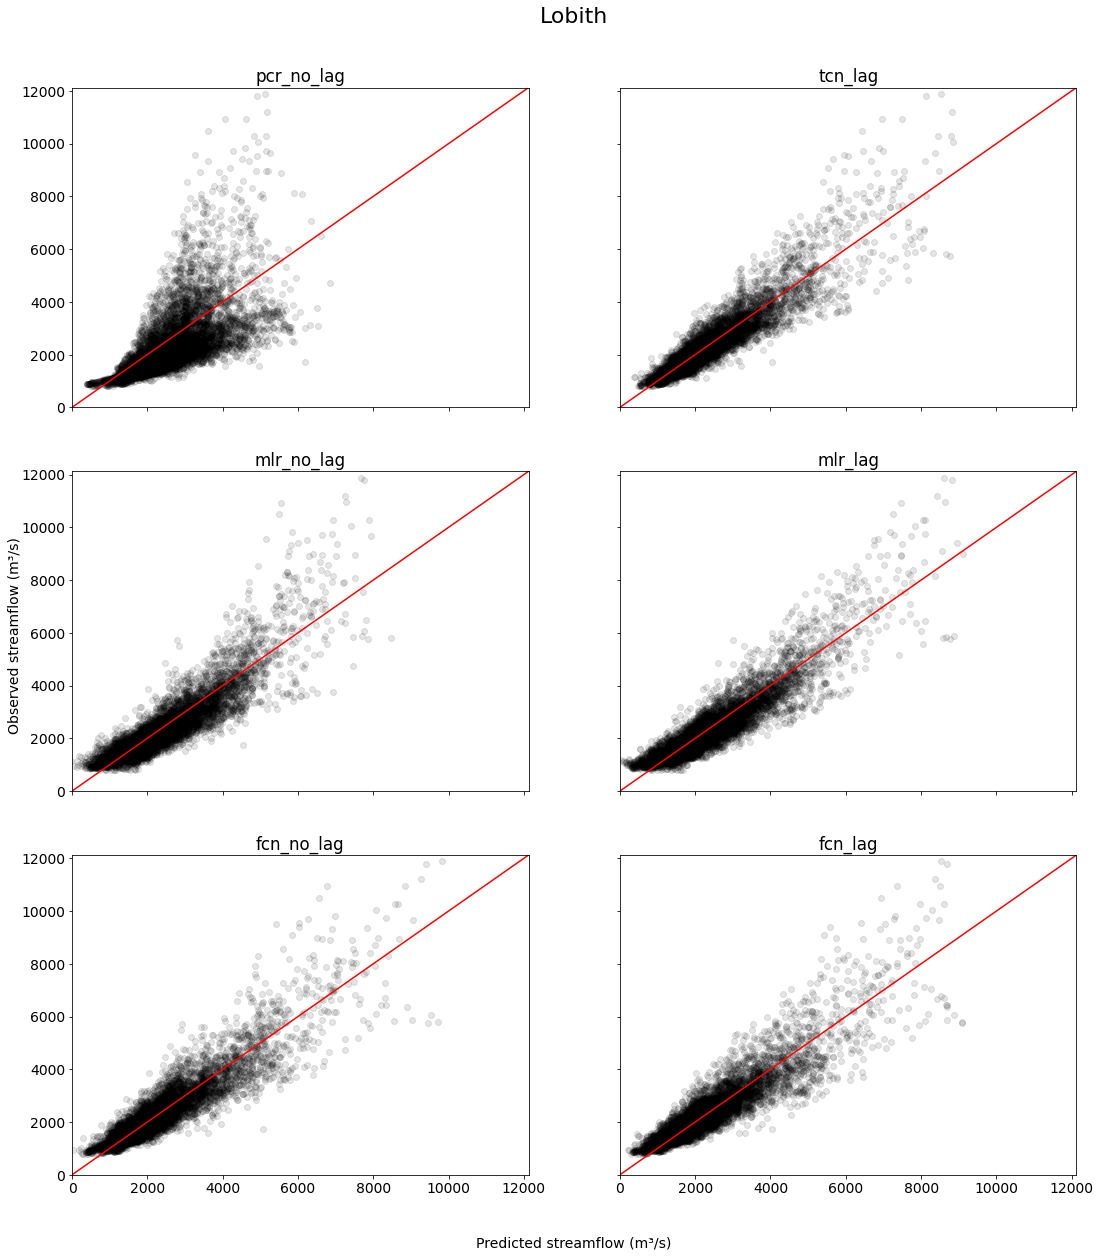

In [6]:
LOCATION = 'lobith'  #location of the data to be plotted

#define what models to use
models = [['pcr', 'no_lag'], ['mlr', 'no_lag'], ['fcn', 'no_lag'], 
          ['tcn', 'lag'], ['mlr', 'lag'], ['fcn', 'lag']]

model_pred = [[] for n in range(len(models))]
model_obs = [[] for n in range(len(models))]

#import the data (change paths to your own)
for i,m in enumerate(models):
  for t in range(1,6):
    with np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/formatted_data/{LOCATION}/{m[1]}_{t}.npz') as f:
      _, _, _, _, obs = list(f.values())
    pred = np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/{m[1]}/{m[0]}/{m[0]}_test_{t}.npy')
    model_pred[i] = np.concatenate((model_pred[i], pred))
    model_obs[i] = np.concatenate((model_obs[i], obs))

#plot the results
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(3,2, sharey = 'all', sharex = 'all', figsize = (18,20))
max_val = max(max(max(m) for m in model_pred), max(max(n) for n in model_obs))*1.02

for i in range(len(models)):
  ax[i%3,(i>2)*1].plot(model_pred[i], model_obs[i], 'ko', alpha = 0.1)
  ax[i%3,(i>2)*1].plot([0,max_val], [0,max_val], 'r')
  ax[i%3,(i>2)*1].set_title(models[i][0] + '_' + models[i][1])
  ax[i%3,(i>2)*1].set_xlim(0, max_val)
  ax[i%3,(i>2)*1].set_ylim(0, max_val)

fig.text(0.512, 0.075, 'Predicted streamflow (m³/s)', ha='center')
fig.text(0.512, 1 - 0.075, LOCATION.capitalize(), ha='center', fontsize = 22)
fig.text(0.075, 0.5, 'Observed streamflow (m³/s)', va='center', rotation='vertical')

#save the figure (change path to your own)
plt.savefig(f'/content/drive/MyDrive/ADS/Final Thesis Project/output/obs_vs_pred_{LOCATION}.png',bbox_inches='tight')

## Cumulative distribution curve

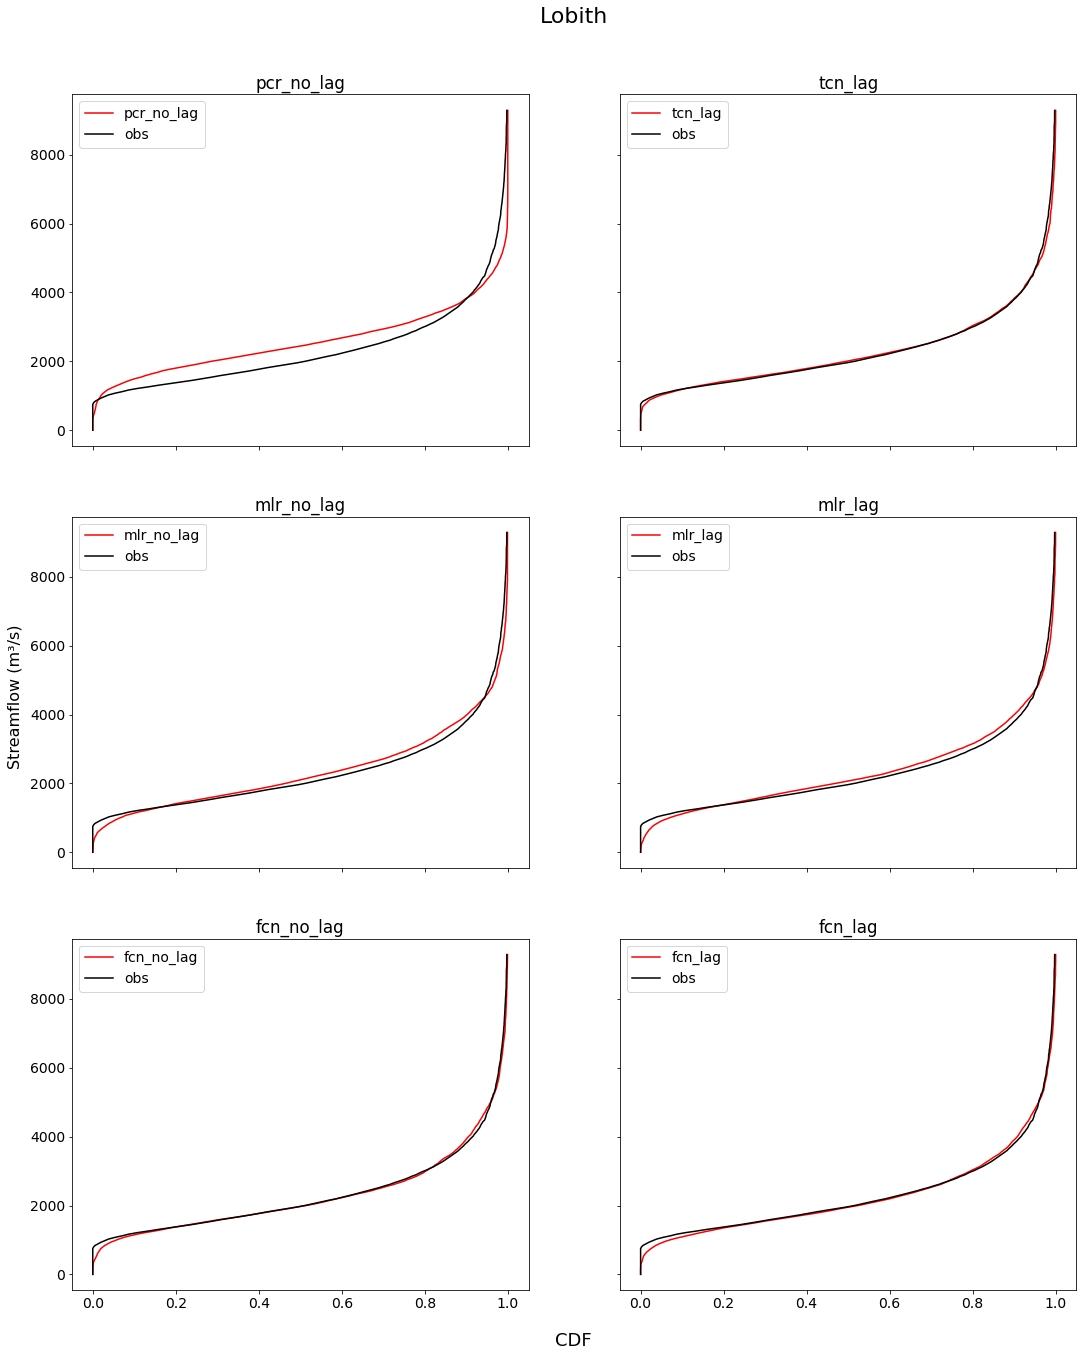

In [ ]:
LOCATION = 'lobith'  #location of the data to be plotted

#define what models to use
models = [['pcr', 'no_lag'], ['mlr', 'no_lag'], ['fcn', 'no_lag'], 
          ['tcn', 'lag'], ['mlr', 'lag'], ['fcn', 'lag']]

model_pred = [[] for n in range(len(models))]
model_obs = [[] for n in range(len(models))]

#import the data (change paths to your own)
for i,m in enumerate(models):
  for t in range(1,6):
    with np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/formatted_data/{LOCATION}/{m[1]}_{t}.npz') as f:
      _, _, _, _, obs = list(f.values())
    pred = np.load(f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/{m[1]}/{m[0]}/{m[0]}_test_{t}.npy')
    model_pred[i] = np.concatenate((model_pred[i], pred))
    model_obs[i] = np.concatenate((model_obs[i], obs))

#set the figure and its parameters
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(3,2, sharey = 'all', sharex = 'all', figsize = (18,22))
maxx = max(max(m) for m in model_pred)*0.95

for i in range(len(models)):

  #obtain the cumulative frequency of obsered and predicted streamflow
  values, base = np.histogram(model_pred[i], weights=np.ones_like(model_pred[i])/len(model_pred[i]), range = (0,maxx), bins=200)
  cumulative = np.cumsum(values)
  values_o, base_o = np.histogram(model_obs[i], weights=np.ones_like(model_obs[i])/len(model_obs[i]), range = (0,maxx), bins=200)
  cumulative_o = np.cumsum(values_o)

  #plot the results
  ax[i%3,(i>2)*1].plot(cumulative, base[:-1], c='red', label = models[i][0] + '_' + models[i][1])
  ax[i%3,(i>2)*1].plot(cumulative_o, base_o[:-1], c='black', label = 'obs')
  ax[i%3,(i>2)*1].set_title(models[i][0] + '_' + models[i][1])
  ax[i%3,(i>2)*1].legend()

#set title and axes labels
fig.text(0.512, 0.09, 'CDF', ha='center', fontsize = 18)
fig.text(0.512, 1 - 0.075, LOCATION.capitalize(), ha='center', fontsize = 22)
fig.text(0.075, 0.5, 'Streamflow (m³/s)', va='center', rotation='vertical', fontsize = 16)

#save the figure (change path to your own)
plt.savefig(f'/content/drive/MyDrive/ADS/Final Thesis Project/output/cum_{LOCATION}.png',bbox_inches='tight')